<a href="https://colab.research.google.com/github/Yui9029/intern_trend_analysis/blob/main/trend_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 必要なライブラリのインポート

In [ ]:
#! pip install prophet
from prophet import Prophet
import pandas as pd          # データ操作用
import matplotlib.pyplot as plt   # グラフ描画用
import statsmodels.api as sm       # 時系列解析用（分解、モデル構築など）
from statsmodels.tsa.stattools import adfuller   # ADF検定用
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF・PACFプロット用
import numpy as np

# 2. CSVファイルの読み込み

In [ ]:
# ※ファイルパスはアップロードされたファイルのパスです
df = pd.read_csv('/content/長期インターン市場_Googleトレンド.csv')

# 3. データの中身を確認して、どのカラムがあるか把握する

In [ ]:

print("=== DataFrameの先頭5行 ===")
print(df.head())
print("\n=== DataFrameのカラム一覧 ===")
print(df.columns)

=== DataFrameの先頭5行 ===
        week  search
0   2020/3/8      34
1  2020/3/15      32
2  2020/3/22      36
3  2020/3/29      27
4   2020/4/5      29

=== DataFrameのカラム一覧 ===
Index(['week', 'search'], dtype='object')


# 4. 日付を表すカラムをdatetime型に変換し、インデックスに設定する

In [ ]:
df['week'] = pd.to_datetime(df['week'])
df = df.set_index('week')
df = df.sort_index()  # 時系列順にソート

# 5. 元の時系列データ（週次データ）のプロット

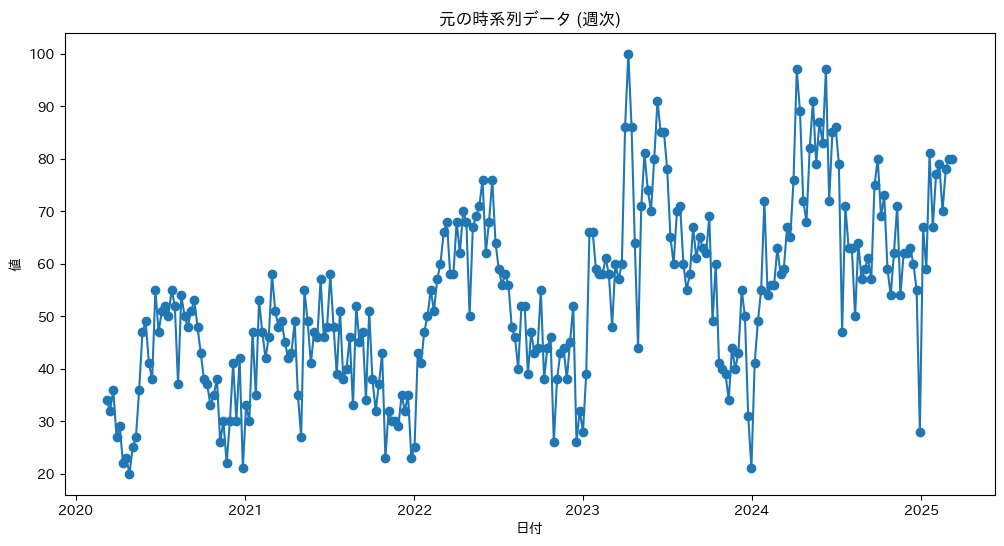

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(df.iloc[:,0], marker='o')
plt.title('元の時系列データ (週次)')
plt.xlabel('日付')
plt.ylabel('値')
plt.show()

# **＜解釈＞**
- なんとなく，周期的な変化があるように見える．

# 6. 季節分解（Seasonal Decompose）による各成分の抽出

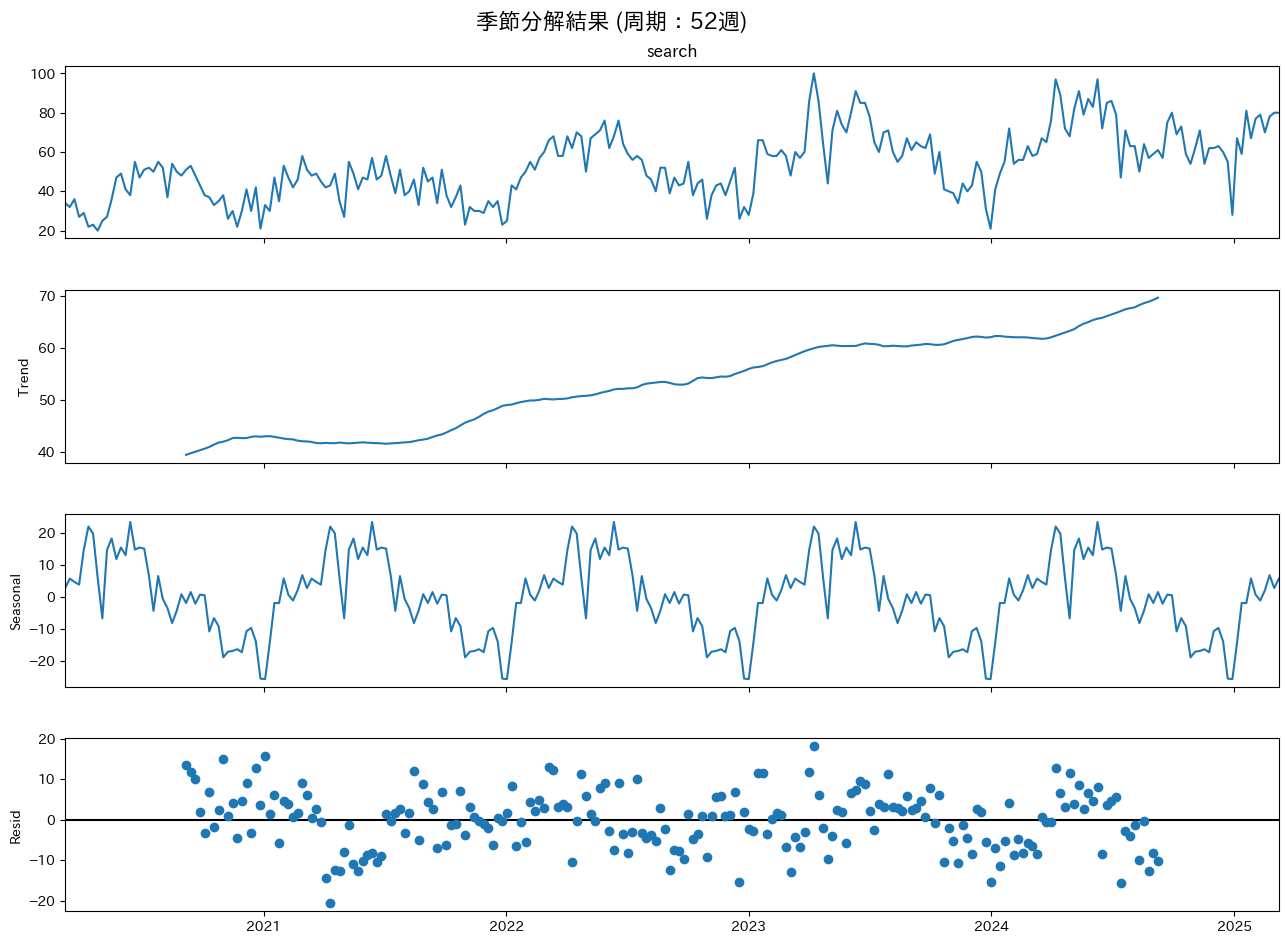

In [ ]:

# 週次データの場合、年間の季節性を考慮して period=52（1年＝52週）を指定します
decomposition = sm.tsa.seasonal_decompose(df.iloc[:,0], model='additive', period=52)
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('季節分解結果 (周期：52週)', fontsize=16)
plt.show()

# **＜解釈＞**

# 図１
- 全体的な推移として，低いところでは20〜30台、高いところでは80〜90近くまで上下しており、明確な上下動が見られます。
- 時間が進むにつれて全体的に値が高くなっているように見える（特に2022年以降、値が上昇している）

# 図２
- 2020年から2025年にかけて、ゆるやかに右肩上がりの曲線を描いています。
- これは、「長期インターン市場」に対する検索需要（関心度）が年々増えている可能性を示唆します。

# 図３
- プラス方向に振れている週は「毎年同じ時期に検索量が増えやすい」、マイナス方向は「毎年同じ時期に検索量が減りやすい」と考えられます．
- 一定の周期がありそう．

# 図４
- 全体的にちらばりが均一のため，特定の追加パターンは見当たらず、単なるノイズ（偶然の上下動）と考えられます。

# **＜総合的な考察＞**

# １．上向きのトレンド
- 長期的に見て、「長期インターン市場」に対する関心が高まりつつある。社会的需要や学生の就職活動への意識変化などが背景にあるかも。

# ２．はっきりした季節性
- 1年単位で似たような時期に需要が上がったり下がったりするパターンがある。

# 7. 定常性の確認：Augmented Dickey-Fuller (ADF)検定

In [ ]:

#    ※一般にp値が0.05未満なら定常性があると判断されます
# ※もしp値が0.05以上の場合は、非定常性が疑われるため、差分等の変換が必要です。
adf_result = adfuller(df.iloc[:,0].dropna())
print("=== 元系列のADF検定結果 ===")
print(f"ADF統計量: {adf_result[0]:.4f}")
print(f"p値: {adf_result[1]:.4f}")


=== 元系列のADF検定結果 ===
ADF統計量: -2.8188
p値: 0.0556


# **＜解釈・補足＞**
- 「このデータは、時間がたっても平均や変動の大きさが変わらない、安定した状態（定常）にあるかどうか」を確かめるテスト。
- もしデータの平均やトレンドが時間とともに変わり続けているなら、その変化を取り除く（差分をとる など）ことで「安定した状態」に近づけることができる。
もう少し詳しく分析してみる必要がある。

# 8. 自己相関 (ACF) と偏自己相関 (PACF) のプロット

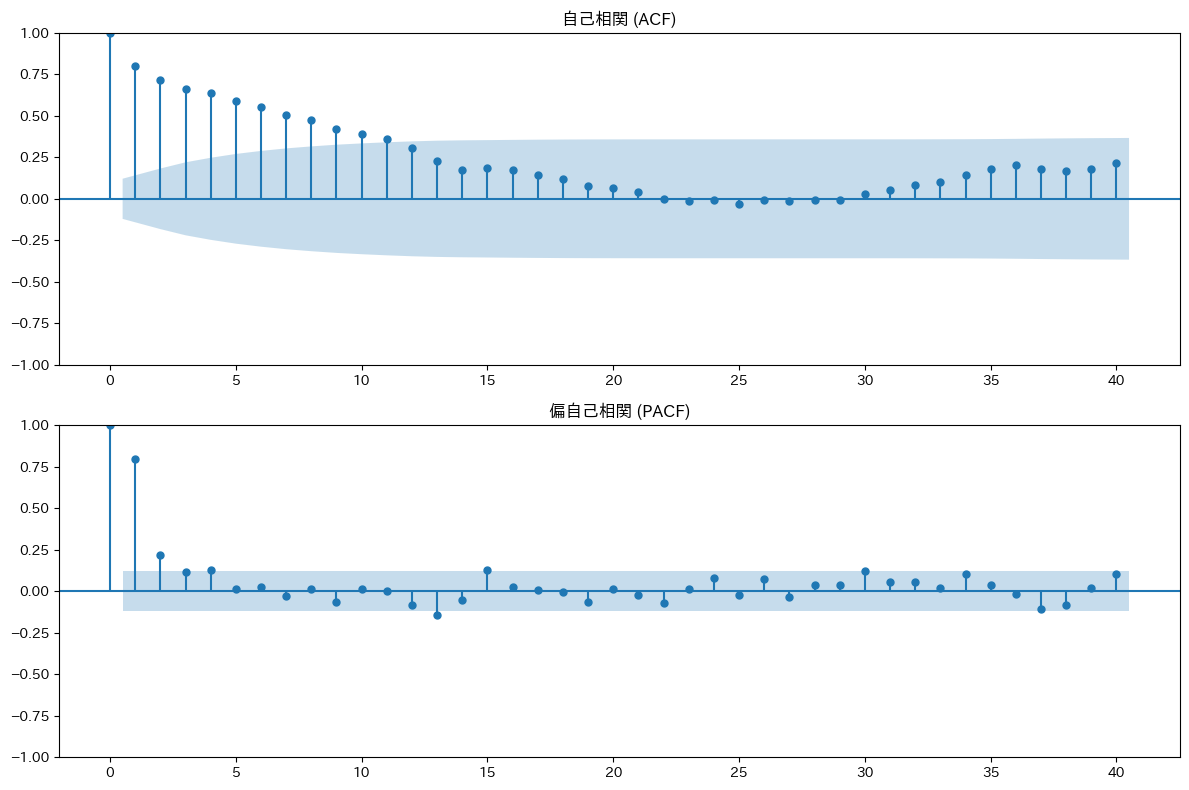

In [ ]:

#    ラグ数は適宜変更してください（ここでは40ラグを例示）
fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df.iloc[:,0].dropna(), ax=ax[0], lags=40)
ax[0].set_title('自己相関 (ACF)')
plot_pacf(df.iloc[:,0].dropna(), ax=ax[1], lags=40)
ax[1].set_title('偏自己相関 (PACF)')
plt.tight_layout()
plt.show()


# **＜解釈・補足＞**

# 1. ACF（自己相関）とは？
- 縦軸: 「相関の強さ」を示す数値（相関係数）。1に近いほど強いプラスの関係、0に近いほど関係が薄い。

- 横軸: 「ラグ（Lag）」と呼ばれ、何週間前のデータと比べているかを表す。
たとえば「Lag = 1」は「1週間前」との関係、「Lag = 2」は「2週間前」との関係。
- 青い棒: そのラグ（何週間前）との相関の強さ。
棒が青い帯（信頼区間）から飛び出している部分は「偶然とは言い切れない、強い相関がある」と考えられる。

# ざっくり解釈
「Lag = 1」が高ければ、「1週間前の値と今の値が似ている」ことを示す。
「Lag = 2」が高ければ、「2週間前の値と今の値が似ている」ことを示す。
もし棒がすぐ小さくなるなら、「直近の数週間だけが影響して、古い週の影響は少ない」と言える。

# 2. PACF（偏自己相関）とは？
- 縦軸: こちらも「相関の強さ」だが、他の週の影響を取り除いた上での純粋な相関。
- 横軸: ACFと同じく「ラグ（何週間前か）」を表す。
- 青い棒: 間にある週の影響を抜いて、「何週間前」と「今」の関係だけを測ったもの。

# ざっくり解釈
ACFで「Lag=2」に棒が高くても、実は「Lag=1（1週間前）」の影響を通じて似ているだけかもしれない。
PACFでは、その「1週間前」の影響を取り除いて「2週間前」との関係をチェックする。
棒が大きければ、「本当に2週間前のデータが今に効いている」ということ。


# 9. 定常性が疑われる場合、1次差分を実施してトレンドを除去する

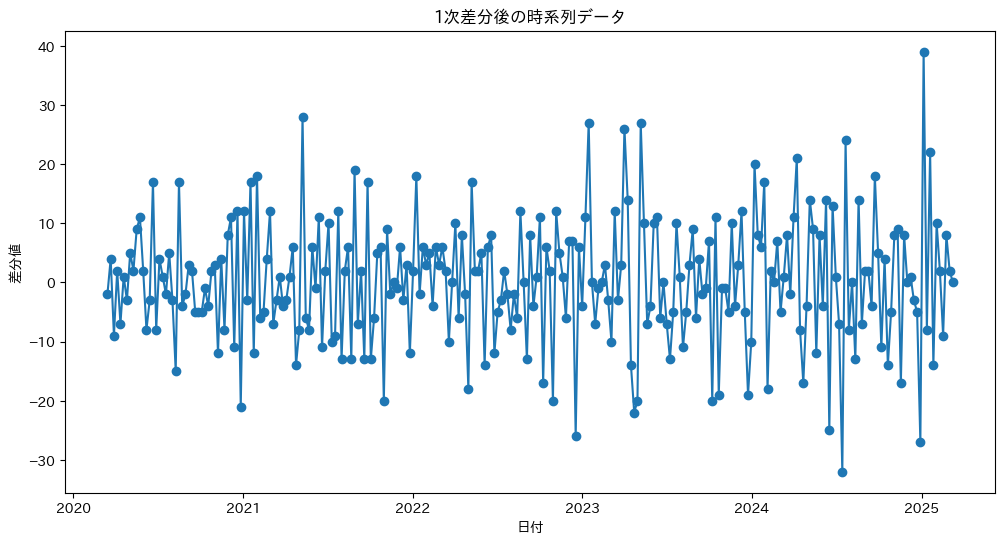

In [ ]:


df_diff = df.iloc[:,0].diff().dropna()

plt.figure(figsize=(12,6))
plt.plot(df_diff, marker='o')
plt.title('1次差分後の時系列データ')
plt.xlabel('日付')
plt.ylabel('差分値')
plt.show()



# **＜解釈・補足＞**

# 何をしたのか？
- 1次差分: 「今日の値」から「昨日（または先週）の値」を引いて、その差を新しいデータとする方法です。
- もともとのデータに大きな上昇・下降の傾向（トレンド）があった場合、差分を取ると、その傾向が取り除かれ、データが上下に振動する形になりやすいです。

# グラフの見方
- 縦軸：差分の値（「今日 - 昨日」のようなもの）
- 横軸：日付
- 点が0付近を中心に、上に行ったり下に行ったりする形になっていれば、「平均がほぼ一定」の状態に近づいたと考えられます。

# ざっくりイメージ
- 差分前: 右肩上がり（または下がり）などのトレンドがあって、定常（安定）とは言えなかった。
- 差分後: トレンドが消え、ランダムに振動しているように見える → 定常に近づいたかもしれない。

# 10. 差分後の系列でADF検定を実施して定常性を確認する

In [ ]:

adf_result_diff = adfuller(df_diff)
print("=== 1次差分系列のADF検定結果 ===")
print(f"ADF統計量: {adf_result_diff[0]:.4f}")
print(f"p値: {adf_result_diff[1]:.4f}")
# ※ p値が0.05未満であれば、差分系列は定常性を持つと判断できます



=== 1次差分系列のADF検定結果 ===
ADF統計量: -13.3095
p値: 0.0000


# **＜解釈・補足＞**

# 何を調べているのか？
- ADF検定は、「このデータは平均や変動の大きさが時間で変わらない“安定した状態”にあるかどうか」を数値的に判定するテストです。

# 今回の結果
- ADF統計量 (例: -13.3095)
- p値 (例: 0.0000 など)
- p値が0.05未満であれば、「安定（定常）になった」と考えられます。

# ざっくりイメージ
- もともとのデータは、時間とともに変化が大きかった（成長や減少があった）けれど、
差分を取った後のデータは「一定の水準のまわりでブレている」ようになり、テストでも「定常的」とみなせる結果が出た
- 大きな変化の流れ（トレンド）を差分で消せたということ。

# 11. 差分系列のACF・PACFプロット（モデル選定の参考に）

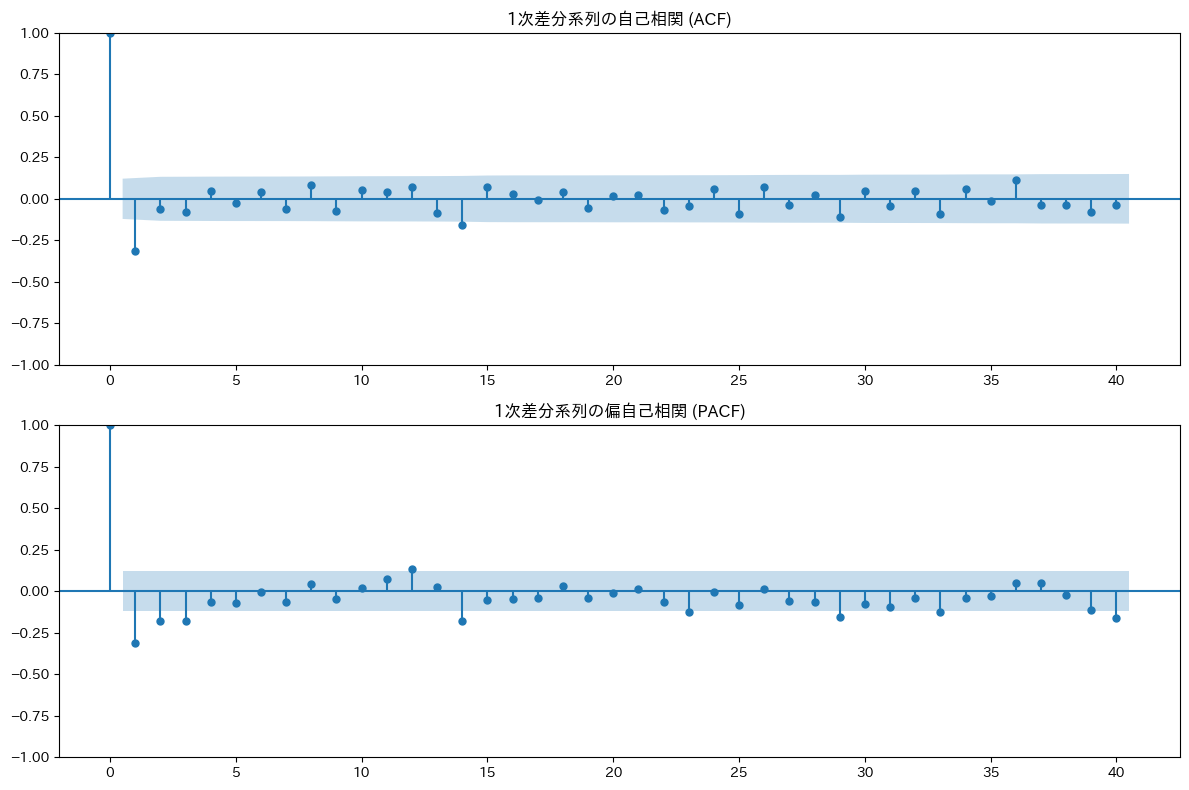

In [ ]:

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df_diff, ax=ax[0], lags=40)
ax[0].set_title('1次差分系列の自己相関 (ACF)')
plot_pacf(df_diff, ax=ax[1], lags=40)
ax[1].set_title('1次差分系列の偏自己相関 (PACF)')
plt.tight_layout()
plt.show()

# **＜解釈・補足＞**

# ACF・PACFとは？
- ACF（自己相関）: 過去のデータとどれくらい似ているかを、いろいろな「何週間前」「何日前」という単位で調べたグラフ。
- PACF（偏自己相関）: 間にある週・日の影響を取り除いて、純粋に「何週間前」との関係だけを見たグラフ。

# なぜ差分系列で見るのか？
- 1次差分後のデータが「定常的（安定している）」になったかどうかをさらに確かめたり、どのくらい前の情報が影響するかを見たりするため。

# ざっくりイメージ
- 差分後のデータは、毎週（または毎日）の増え方や減り方を表すイメージ。
- ACF/PACFのグラフで、最初の方（Lag=1,2など）だけ棒が大きければ、「1週間前、2週間前の増減が今週の増減に効いている」かもしれない。
- 棒がすぐに小さくなるなら、「あまり過去の増減は引きずらず、近い週だけが影響する」。

In [ ]:

from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語フォントを使いたい場合


# 12.Facebook Prophet による予測分析

In [ ]:


# Prophet用に「ds」(日付) と「y」(数値) という2列を持つDataFrameを作成
df_prophet = df.reset_index()  # インデックス -> カラムへ
df_prophet.columns = ['ds', 'y']  # 'week' -> 'ds', '検索量カラム' -> 'y'

# ds列をdatetime型に（念のため）
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

print(df_prophet.head())


          ds   y
0 2020-03-08  34
1 2020-03-15  32
2 2020-03-22  36
3 2020-03-29  27
4 2020-04-05  29


In [ ]:
# Prophetのインスタンスを作成
# yearly_seasonality=True -> 年間の季節性を考慮
# weekly_seasonality=False -> 週ごとの季節性は使わない(すでに週次データのため)
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False
)

# 学習
model.fit(df_prophet)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_6znd8q/ui2weh8r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_6znd8q/z3tj26_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21511', 'data', 'file=/tmp/tmpe_6znd8q/ui2weh8r.json', 'init=/tmp/tmpe_6znd8q/z3tj26_i.json', 'output', 'file=/tmp/tmpe_6znd8q/prophet_modelpz2q0b2b/prophet_model-20250312124159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:41:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:41:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# 52週間先まで予測
future = model.make_future_dataframe(periods=52, freq='W')  # 週単位
forecast = model.predict(future)

# 予測結果の確認
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


            ds       yhat  yhat_lower  yhat_upper
309 2026-02-08  78.538489   67.055800   89.751292
310 2026-02-15  79.743501   67.789534   91.130139
311 2026-02-22  84.727132   73.446274   95.904753
312 2026-03-01  87.439728   75.760623   98.852965
313 2026-03-08  85.026031   73.611668   96.609497


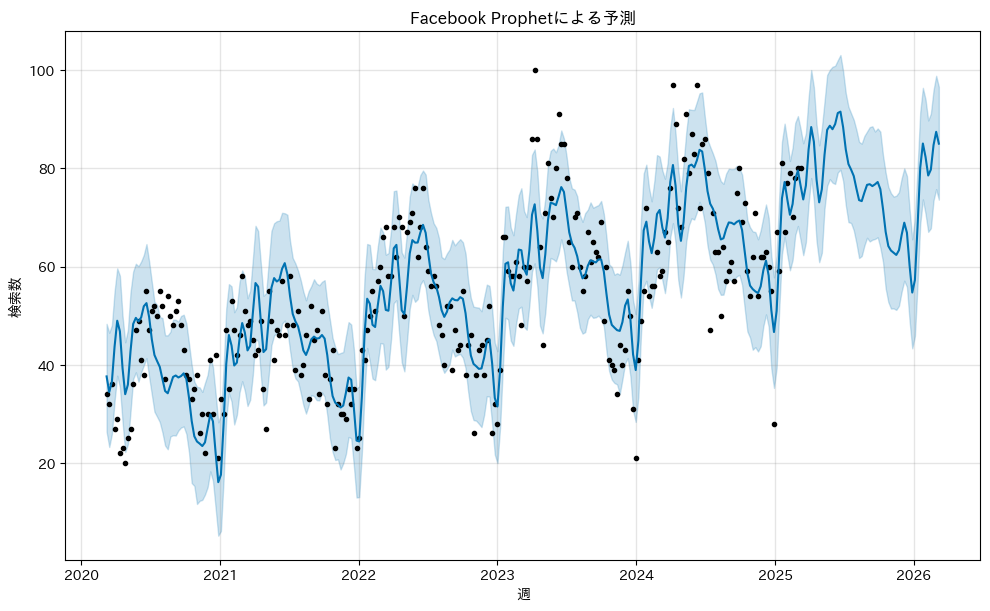

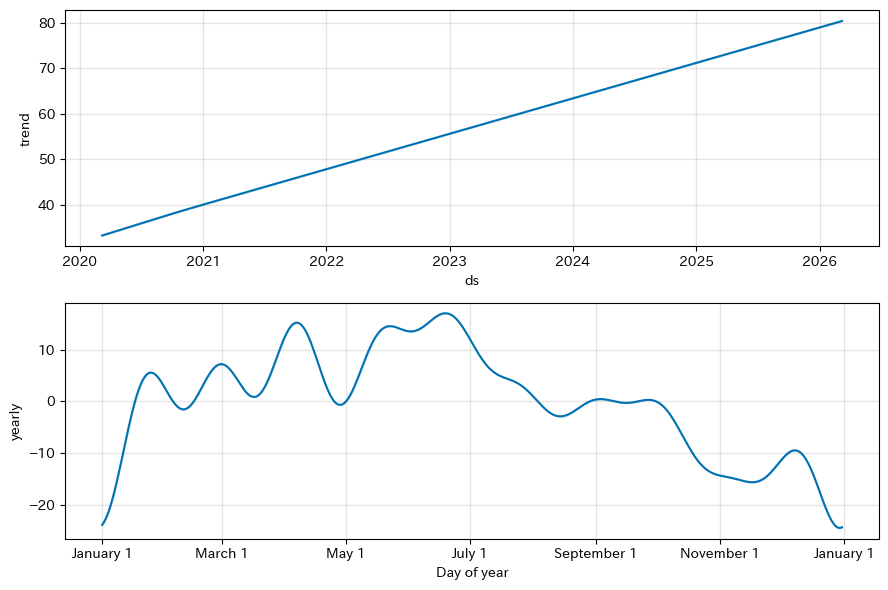

In [ ]:
# 予測曲線をプロット
fig1 = model.plot(forecast)
plt.title('Facebook Prophetによる予測')
plt.xlabel('週')
plt.ylabel('検索数')
plt.show()

# 季節性やトレンドを分解した図を表示
fig2 = model.plot_components(forecast)
plt.show()


# 13. SARIMAによる予測分析

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
# df.iloc[:, 0] に検索数が入っていると仮定
# (p, d, q) と (P, D, Q, 52) は暫定的な例です。実際にはACF/PACFやAICなどで調整します。

p, d, q = 1, 1, 1       # 非季節要素
P, D, Q, s = 1, 1, 1, 52  # 季節要素(52週)

# SARIMAXモデルを定義
model_sarima = SARIMAX(
    df.iloc[:, 0],              # 解析対象の時系列データ
    order=(p, d, q),            # 非季節要素の(p,d,q)
    seasonal_order=(P, D, Q, s) # 季節要素の(P,D,Q,s)
)
results_sarima = model_sarima.fit(disp=False)
print(results_sarima.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                             search   No. Observations:                  262
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -764.573
Date:                            Wed, 12 Mar 2025   AIC                           1539.146
Time:                                    12:44:04   BIC                           1555.857
Sample:                                03-08-2020   HQIC                          1545.902
                                     - 03-09-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0043      0.098     -0.044      0.965      -0.197       0.188
ma.L1         -0.6949      0.073   

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima

# seasonal=True, m=52 -> 週次で1年=52週を想定
stepwise_model = auto_arima(
    df.iloc[:,0],
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=3, max_Q=3,
    m=52,               # 季節周期
    seasonal=True,
    d=1, D=1,          # とりあえず1次差分,1次季節差分を試す
    trace=True,        # 途中経過を表示
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(stepwise_model.summary())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1644.870, Time=0.94 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1568.699, Time=5.47 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[52]             : AIC=1535.626, Time=6.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,0)[52]             : AIC=1559.003, Time=0.67 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,1)[52]             : AIC=1537.147, Time=9.86 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,2)[52]             : AIC=1536.802, Time=26.04 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,0)[52]             : AIC=1537.234, Time=4.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,1,2)[52]             : AIC=inf, Time=142.44 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,1)[52]             : AIC=1615.115, Time=11.78 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,1)[52]             : AIC=1537.626, Time=11.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,1,1)[52]             : AIC=1537.626, Time=10.39 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,1)[52]             : AIC=1564.880, Time=6.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[52]             : AIC=1536.839, Time=28.00 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=1537.617, Time=10.36 sec

Best model:  ARIMA(0,1,1)(0,1,1)[52]          
Total fit time: 275.042 seconds
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  262
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -764.813
Date:                            Wed, 12 Mar 2025   AIC                           1535.626
Time:                                    12:51:28   BIC                           1545.653
Sample:                                03-08-2020   HQIC                          1539.680
                                     - 03-09-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

In [ ]:
# 最適化した値を使用
p, d, q = 0, 1, 1       # 非季節要素
P, D, Q, s = 0, 1, 1, 52  # 季節要素(52週)

# SARIMAXモデルを定義
model_sarima = SARIMAX(
    df.iloc[:, 0],              # 解析対象の時系列データ
    order=(p, d, q),            # 非季節要素の(p,d,q)
    seasonal_order=(P, D, Q, s) # 季節要素の(P,D,Q,s)
)
results_sarima = model_sarima.fit(disp=False)
print(results_sarima.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                             search   No. Observations:                  262
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -764.813
Date:                            Wed, 12 Mar 2025   AIC                           1535.626
Time:                                    12:57:26   BIC                           1545.653
Sample:                                03-08-2020   HQIC                          1539.680
                                     - 03-09-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6963      0.050    -13.989      0.000      -0.794      -0.599
ma.S.L52      -0.4130      0.081   

In [ ]:
# 52週間先まで予測してみる
n_forecast = 52

# end=最終時点, periods=n_forecast -> 52週先まで予測
forecast_sarima = results_sarima.get_forecast(steps=n_forecast)
pred_ci = forecast_sarima.conf_int()  # 予測区間

# 予測値をSeriesに
pred_mean = forecast_sarima.predicted_mean


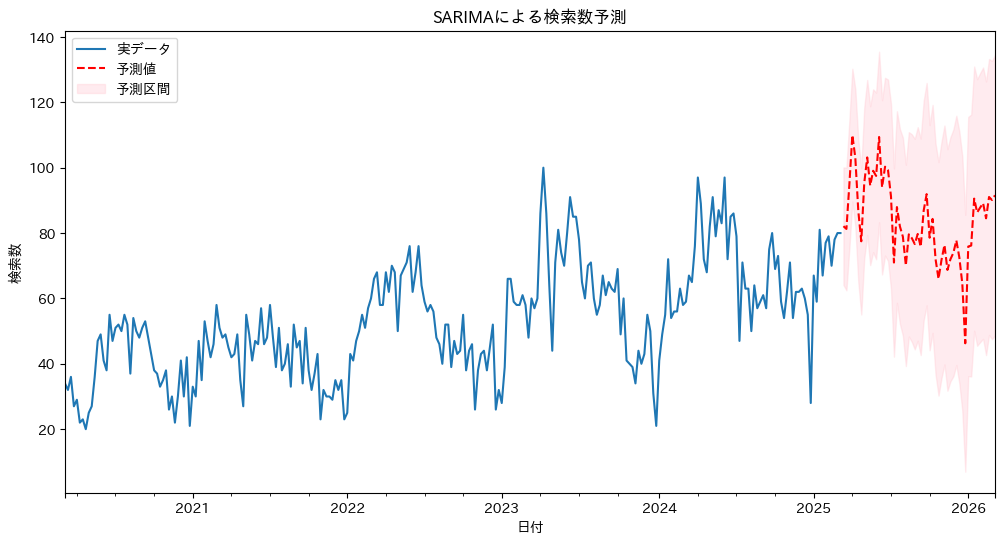

In [ ]:
# 過去のデータと予測をつなげて可視化
fig, ax = plt.subplots(figsize=(12,6))

# 過去データ
df.iloc[:, 0].plot(ax=ax, label='実データ')

# 予測区間の開始日を、元のデータの最後の日付の次からに設定
pred_mean.plot(ax=ax, style='r--', label='予測値')

# 予測区間(上下限)
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:, 0],
    pred_ci.iloc[:, 1],
    color='pink', alpha=0.3, label='予測区間'
)

plt.title('SARIMAによる検索数予測')
plt.xlabel('日付')
plt.ylabel('検索数')
plt.legend()
plt.show()


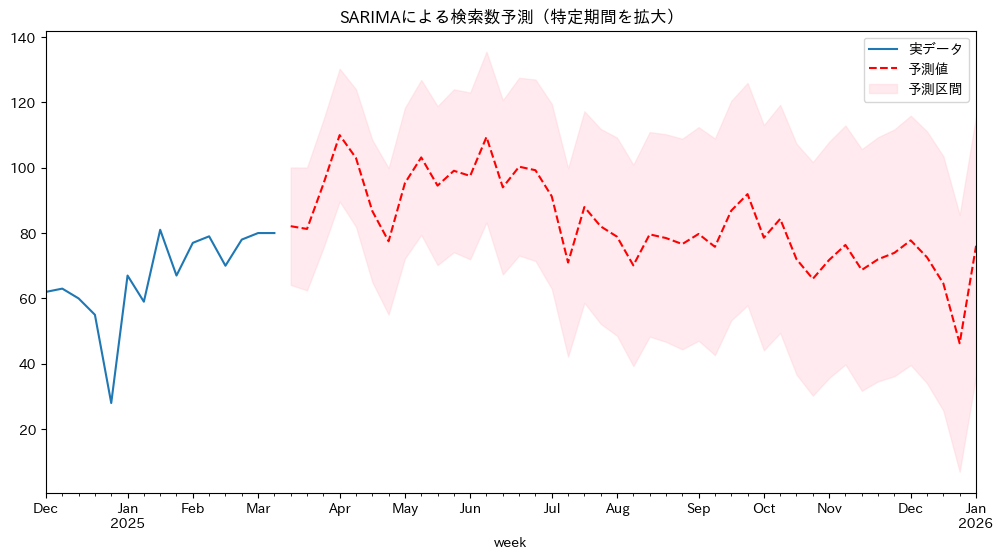

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

# 過去データと予測を描画
df.iloc[:,0].plot(ax=ax, label='実データ')
pred_mean.plot(ax=ax, style='r--', label='予測値')
ax.fill_between(
    pred_ci.index,
    pred_ci.iloc[:,0],
    pred_ci.iloc[:,1],
    color='pink', alpha=0.3, label='予測区間'
)

# x軸の表示範囲を設定（例: 2024年末から2026年まで）
ax.set_xlim(['2024-12-01', '2026-01-01'])

plt.title('SARIMAによる検索数予測（特定期間を拡大）')
plt.legend()
plt.show()
